# Deep Learning Assignment 2

Constructing two different baseline architectures: BiLSTM and Attention-pooled BiGRU to predict semantic similarity between legal clauses.


## 1. Imports & Global Setup


In [1]:
import random
import time
import copy
import re
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, auc, confusion_matrix, classification_report, precision_recall_curve, roc_curve


plt.style.use('ggplot')

SEED = globals().get("SEED", 100)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

def _get_mps_preferred_device():
    try:
        mps = getattr(torch.backends, "mps", None)
        if mps is not None and mps.is_available() and mps.is_built():
            return torch.device("mps")
    except Exception:
        pass
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device = _get_mps_preferred_device()
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

print("Using device:", device)


Using device: mps


In [2]:
# Determinism knobs for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2. Clause-Level Splits & Pair Sampling

We first load every clause text per category, split the _clauses_ into train/val/test buckets, and only then form positive/negative clause pairs within each split to avoid leakage.


In [3]:
# --- Clause-level split + pair building ---
from sklearn.model_selection import train_test_split

DATA_DIR = Path('nlp_dataset')
MIN_CLAUSES_PER_LABEL = 2
NEG_POS_RATIO = 1.0
POSITIVE_PAIRS_PER_CLAUSE = 1
SEED = 67
rng = random.Random(SEED)


# 1) Load clauses per label (prefer in-file clause_type column when present)
label_to_texts = {}
for file in sorted(DATA_DIR.glob('*.csv')):
    df = pd.read_csv(file).dropna(subset=['clause_text'])
    df['clause_text'] = df['clause_text'].astype(str).str.strip()
    df = df[df['clause_text'].str.len() > 0]
    label_col = 'clause_type' if 'clause_type' in df.columns else None
    if label_col:
        for lab, group in df.groupby(label_col):
            texts = group['clause_text'].tolist()
            if len(texts) >= MIN_CLAUSES_PER_LABEL:
                label_to_texts.setdefault(str(lab), []).extend(texts)
    else:
        if len(df) >= MIN_CLAUSES_PER_LABEL:
            label_to_texts[file.stem] = df['clause_text'].tolist()

labels = sorted(label_to_texts)
print(f"Clause categories: {len(labels)}; total clauses: {sum(len(v) for v in label_to_texts.values()):,}")

# 2) Split at the clause level per label
def split_texts(texts):
    texts = list(texts)
    if len(texts) < 4:
        return texts, [], []
    tr, temp = train_test_split(texts, test_size=0.3, random_state=SEED)
    if len(temp) < 2:
        return tr, temp, []
    va, te = train_test_split(temp, test_size=0.5, random_state=SEED)
    return tr, va, te

split = {'train': {}, 'val': {}, 'test': {}}
split_stats = {}
for lab in labels:
    tr, va, te = split_texts(label_to_texts[lab])
    split['train'][lab] = tr
    split['val'][lab] = va
    split['test'][lab] = te

for name, bucket in split.items():
    clauses = sum(len(v) for v in bucket.values())
    label_count = sum(1 for v in bucket.values() if len(v) > 0)
    split_stats[name] = {'clauses': clauses, 'labels': label_count}
    print(f"{name.title()} split: {clauses:,} clauses across {label_count:,} labels")

# 3) Build balanced pairs within each split
def build_pairs_for_split(bucket):
    labs = [lab for lab, texts in bucket.items() if len(texts) > 0]
    pos, neg = [], []
    for lab in labs:
        texts = bucket[lab]
        if len(texts) < 2:
            continue
        for clause in texts:
            for _ in range(POSITIVE_PAIRS_PER_CLAUSE):
                partner = rng.choice(texts)
                while partner == clause and len(texts) > 1:
                    partner = rng.choice(texts)
                pos.append((clause, partner, 1))
    num_neg = int(len(pos) * NEG_POS_RATIO)
    for _ in range(num_neg):
        la, lb = rng.sample(labs, 2)
        a = rng.choice(bucket[la]) if bucket[la] else None
        b = rng.choice(bucket[lb]) if bucket[lb] else None
        if a and b:
            neg.append((a, b, 0))
    pairs = pos + neg
    rng.shuffle(pairs)
    return pd.DataFrame(pairs, columns=['text_a', 'text_b', 'label'])

train_df = build_pairs_for_split(split['train']).reset_index(drop=True)
val_df = build_pairs_for_split(split['val']).reset_index(drop=True)
test_df = build_pairs_for_split(split['test']).reset_index(drop=True)
pair_counts = {'train': len(train_df), 'val': len(val_df), 'test': len(test_df)}
print(f"Pair counts -> train: {pair_counts['train']:,}, val: {pair_counts['val']:,}, test: {pair_counts['test']:,}")
print(f"Negative/positive ratio: {NEG_POS_RATIO}:1")
train_df.head()

Clause categories: 395; total clauses: 150,881
Train split: 105,614 clauses across 395 labels
Val split: 22,530 clauses across 395 labels
Test split: 22,737 clauses across 395 labels
Pair counts -> train: 211,228, val: 45,060, test: 45,474
Negative/positive ratio: 1.0:1
Pair counts -> train: 211,228, val: 45,060, test: 45,474
Negative/positive ratio: 1.0:1


,text_a,text_b,label
0,Indemnification by the Company. (a) The Compan...,Effective Date. (1) This Amending Agreement sh...,0
1,Notice of Defaults. Company shall notify Bank ...,Loans. The proceeds of the Loans hereunder wil...,0
2,Restrictive Covenants. 7.1 Executive acknowled...,Restrictive Covenants. 12.1 For the purpose of...,1
3,Compensation and Benefits. Upon a termination ...,Compensation and Benefits. As consideration fo...,1
4,Management. The Owner covenants and agrees tha...,Purchase Price. Each Right entitles the regist...,0


## 3. Tokenization & Numericalization


In [4]:
TOKEN_PATTERN = re.compile(r"[A-Za-z']+")

def tokenize(text: str):
    return TOKEN_PATTERN.findall(text.lower())

counter = Counter()
for text in pd.concat([train_df['text_a'], train_df['text_b']]):
    counter.update(tokenize(text))

MAX_VOCAB = 30000
most_common = counter.most_common(MAX_VOCAB - 2)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}
PAD_IDX = 0
UNK_IDX = 1
MAX_SEQ_LEN = 150

print('Vocab size:', len(vocab) + 2)
print('Top tokens:', counter.most_common(10))

Vocab size: 30000
Top tokens: [('the', 3197217), ('of', 2044991), ('or', 1496157), ('and', 1446514), ('to', 1363790), ('any', 930135), ('in', 903373), ('shall', 556695), ('be', 524562), ('a', 514453)]


In [5]:
def encode(text: str):
    tokens = tokenize(text)
    ids = [vocab.get(tok, UNK_IDX) for tok in tokens][:MAX_SEQ_LEN]
    if len(ids) < MAX_SEQ_LEN:
        ids += [PAD_IDX] * (MAX_SEQ_LEN - len(ids))
    return ids


def encode_dataframe(df):
    left = np.array([encode(t) for t in df['text_a']], dtype=np.int64)
    right = np.array([encode(t) for t in df['text_b']], dtype=np.int64)
    labels = df['label'].astype(np.float32).values
    return left, right, labels

train_left, train_right, train_labels = encode_dataframe(train_df)
val_left, val_right, val_labels = encode_dataframe(val_df)
test_left, test_right, test_labels = encode_dataframe(test_df)
print('Encoded shapes ->', train_left.shape, val_left.shape, test_left.shape)

Encoded shapes -> (211228, 150) (45060, 150) (45474, 150)


## 4. PyTorch Datasets & Loaders


In [6]:
class PairDataset(Dataset):
    def __init__(self, left, right, labels):
        self.left = left
        self.right = right
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.left[idx], dtype=torch.long),
            torch.tensor(self.right[idx], dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

BATCH_SIZE = 64
train_loader = DataLoader(PairDataset(train_left, train_right, train_labels), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(PairDataset(val_left, val_right, val_labels), batch_size=BATCH_SIZE)
test_loader = DataLoader(PairDataset(test_left, test_right, test_labels), batch_size=BATCH_SIZE)

## 5. Training Utilities & Early Stopping


In [7]:
criterion = nn.BCEWithLogitsLoss()


def compute_metrics(probs, targets):
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(targets, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='binary', zero_division=0)
    try:
        roc = roc_auc_score(targets, probs)
    except ValueError:
        roc = float('nan')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc}


def run_epoch(model, loader, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss = 0.0
    probs_list, targets_list = [], []
    for left, right, labels in loader:
        left = left.to(device)
        right = right.to(device)
        labels = labels.to(device)
        logits = model(left, right).squeeze(1)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
        total_loss += loss.item() * labels.size(0)
        probs_list.append(torch.sigmoid(logits).detach().cpu().numpy())
        targets_list.append(labels.detach().cpu().numpy())
    probs_all = np.concatenate(probs_list)
    targets_all = np.concatenate(targets_list)
    metrics = compute_metrics(probs_all, targets_all)
    return total_loss / len(loader.dataset), metrics


def train_model(model, train_loader, val_loader, epochs=12, lr=1e-3, weight_decay=1e-4, patience=3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    history = []
    best_state, best_f1 = None, -1
    epochs_without_improve = 0
    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = run_epoch(model, train_loader, optimizer)
        val_loss, val_metrics = run_epoch(model, val_loader)
        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_metrics': train_metrics,
            'val_metrics': val_metrics
        })
        if val_metrics['f1'] > best_f1 + 1e-4:
            best_f1 = val_metrics['f1']
            best_state = copy.deepcopy(model.state_dict())
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_f1={val_metrics['f1']:.4f}")
        if epochs_without_improve >= patience:
            print('Early stopping triggered.')
            break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

## 6. RNN Architectures


In [8]:
class BiLSTMSiamese(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        rep_dim = hidden_size * 2
        self.projection = nn.Sequential(
            nn.LayerNorm(rep_dim),
            nn.Linear(rep_dim, rep_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.head = nn.Sequential(
            nn.Linear(rep_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def encode(self, x):
        mask = (x != PAD_IDX).unsqueeze(-1)
        emb = self.embedding(x)
        output, _ = self.lstm(emb)
        output = output * mask
        summed = output.sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1).float()
        mean_pooled = summed / lengths
        return self.projection(self.dropout(mean_pooled))

    def forward(self, left, right):
        left_vec = self.encode(left)
        right_vec = self.encode(right)
        combined = torch.cat([left_vec, right_vec, torch.abs(left_vec - right_vec), left_vec * right_vec], dim=1)
        return self.head(combined)


class AttentiveGRUSiamese(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=128, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.attn_vector = nn.Parameter(torch.randn(hidden_size * 2))
        self.dropout = nn.Dropout(dropout)
        rep_dim = hidden_size * 2
        self.head = nn.Sequential(
            nn.Linear(rep_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def encode(self, x):
        pad_mask = (x == PAD_IDX)
        emb = self.embedding(x)
        outputs, _ = self.gru(emb)
        scores = torch.matmul(outputs, self.attn_vector)
        scores = scores.masked_fill(pad_mask, float('-inf'))
        attn = torch.softmax(scores, dim=1).unsqueeze(-1)
        context = torch.sum(outputs * attn, dim=1)
        return self.dropout(context)

    def forward(self, left, right):
        left_vec = self.encode(left)
        right_vec = self.encode(right)
        combined = torch.cat([left_vec, right_vec, torch.abs(left_vec - right_vec), left_vec * right_vec], dim=1)
        return self.head(combined)

## 7. Train & Evaluate – BiLSTM Siamese


In [9]:
EPOCHS = 50
LR = 1e-3
PATIENCE = 3
WEIGHT_DECAY = 1e-4

histories = {}
results = {}

bilstm_model = BiLSTMSiamese(len(vocab) + 2)
start = time.time()
bilstm_model, bilstm_history = train_model(
    bilstm_model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)
bilstm_time = time.time() - start
bilstm_test_loss, bilstm_test_metrics = run_epoch(bilstm_model, test_loader)
print("\nBiLSTM Test Loss:", bilstm_test_loss)
print('BiLSTM Test Metrics:', bilstm_test_metrics)

histories['BiLSTM'] = bilstm_history
results['BiLSTM'] = {**bilstm_test_metrics, 'loss': bilstm_test_loss, 'train_time_sec': bilstm_time}

Epoch 01 | train_loss=0.3959 val_loss=0.2898 val_f1=0.9184
Epoch 02 | train_loss=0.1400 val_loss=0.2184 val_f1=0.9467
Epoch 02 | train_loss=0.1400 val_loss=0.2184 val_f1=0.9467
Epoch 03 | train_loss=0.1099 val_loss=0.2601 val_f1=0.9433
Epoch 03 | train_loss=0.1099 val_loss=0.2601 val_f1=0.9433
Epoch 04 | train_loss=0.0907 val_loss=0.2262 val_f1=0.9491
Epoch 04 | train_loss=0.0907 val_loss=0.2262 val_f1=0.9491
Epoch 05 | train_loss=0.0753 val_loss=0.1963 val_f1=0.9489
Epoch 05 | train_loss=0.0753 val_loss=0.1963 val_f1=0.9489
Epoch 06 | train_loss=0.0647 val_loss=0.1562 val_f1=0.9629
Epoch 06 | train_loss=0.0647 val_loss=0.1562 val_f1=0.9629
Epoch 07 | train_loss=0.0559 val_loss=0.1794 val_f1=0.9622
Epoch 07 | train_loss=0.0559 val_loss=0.1794 val_f1=0.9622
Epoch 08 | train_loss=0.0452 val_loss=0.1603 val_f1=0.9597
Epoch 08 | train_loss=0.0452 val_loss=0.1603 val_f1=0.9597
Epoch 09 | train_loss=0.0405 val_loss=0.1933 val_f1=0.9584
Early stopping triggered.
Epoch 09 | train_loss=0.0405 v

## 8. Train & Evaluate – Attentive BiGRU Siamese


In [17]:
attn_gru_model = AttentiveGRUSiamese(len(vocab) + 2)
start = time.time()
attn_gru_model, attn_gru_history = train_model(
    attn_gru_model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)
attn_gru_time = time.time() - start
attn_gru_test_loss, attn_gru_test_metrics = run_epoch(attn_gru_model, test_loader)
print("\nAttentive GRU Test Loss:", attn_gru_test_loss)
print('Attentive GRU Test Metrics:', attn_gru_test_metrics)

histories['AttentiveGRU'] = attn_gru_history
results['AttentiveGRU'] = {**attn_gru_test_metrics, 'loss': attn_gru_test_loss, 'train_time_sec': attn_gru_time}

KeyboardInterrupt: 

# 9. TF-IDF + Logistic Regression Baseline

In [11]:
# --- Classical TF-IDF baseline ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, auc

print("Training TF-IDF baseline (logistic regression)...")
tfidf_train_X = (train_df['text_a'] + " [SEP] " + train_df['text_b']).values
tfidf_val_X = (val_df['text_a'] + " [SEP] " + val_df['text_b']).values
tfidf_test_X = (test_df['text_a'] + " [SEP] " + test_df['text_b']).values

best_c, best_f1 = 1.0, -1.0
for C in [0.1, 0.3, 1.0, 3.0, 10.0]:
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1, 2), lowercase=True, token_pattern=r"[A-Za-z']+")),
        ("clf", LogisticRegression(max_iter=1000, C=C, solver="liblinear"))
    ])
    pipe.fit(tfidf_train_X, train_df['label'].values)
    val_probs = pipe.predict_proba(tfidf_val_X)[:, 1]
    val_preds = (val_probs >= 0.5).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(val_df['label'].values, val_preds, average='binary', zero_division=0)
    if f1 > best_f1:
        best_f1, best_c = f1, C

print(f"Best C on val: {best_c} (F1={best_f1:.4f})")
tfidf_full = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1, 2), lowercase=True, token_pattern=r"[A-Za-z']+")),
    ("clf", LogisticRegression(max_iter=1000, C=best_c, solver="liblinear"))
])

start = time.time()
tfidf_full.fit(
    np.concatenate([tfidf_train_X, tfidf_val_X]),
    np.concatenate([train_df['label'].values, val_df['label'].values])
)
tfidf_time = time.time() - start

tfidf_test_probs = tfidf_full.predict_proba(tfidf_test_X)[:, 1]
tfidf_metrics = compute_metrics(tfidf_test_probs, test_df['label'].values)
print("TF-IDF baseline:", tfidf_metrics)
results['TFIDF'] = {**tfidf_metrics, 'loss': float('nan'), 'train_time_sec': tfidf_time}

Training TF-IDF baseline (logistic regression)...
Best C on val: 10.0 (F1=0.6355)
Best C on val: 10.0 (F1=0.6355)
TF-IDF baseline: {'accuracy': 0.6158244271451818, 'precision': 0.6074678637012855, 'recall': 0.6547037867792584, 'f1': 0.6302019389526269, 'roc_auc': 0.6563127236985242}
TF-IDF baseline: {'accuracy': 0.6158244271451818, 'precision': 0.6074678637012855, 'recall': 0.6547037867792584, 'f1': 0.6302019389526269, 'roc_auc': 0.6563127236985242}


=== BiLSTM Confusion Matrix ===
[[20923  1814]
 [    0 22737]]
=== BiLSTM Classification Report ===
              precision    recall  f1-score   support

         0.0     1.0000    0.9202    0.9585     22737
         1.0     0.9261    1.0000    0.9616     22737

    accuracy                         0.9601     45474
   macro avg     0.9631    0.9601    0.9600     45474
weighted avg     0.9631    0.9601    0.9600     45474

=== AttentiveGRU Confusion Matrix ===
[[22458   279]
 [    0 22737]]
=== AttentiveGRU Classification Report ===
              precision    recall  f1-score   support

         0.0     1.0000    0.9877    0.9938     22737
         1.0     0.9879    1.0000    0.9939     22737

    accuracy                         0.9939     45474
   macro avg     0.9939    0.9939    0.9939     45474
weighted avg     0.9939    0.9939    0.9939     45474

=== TFIDF Confusion Matrix ===
[[13118  9619]
 [ 7851 14886]]
=== TFIDF Classification Report ===
              precision    recall  f

,accuracy,precision,recall,f1,roc_auc,pr_auc,train_time_sec,loss
BiLSTM,0.960109,0.926113,1.000000,0.961639,0.996446,0.994402,2340.988493,0.157674
AttentiveGRU,0.993865,0.987878,1.000000,0.993902,0.999893,0.999817,4986.730818,0.023373
TFIDF,0.615824,0.607468,0.654704,0.630202,0.656313,0.630872,79.630193,NaN


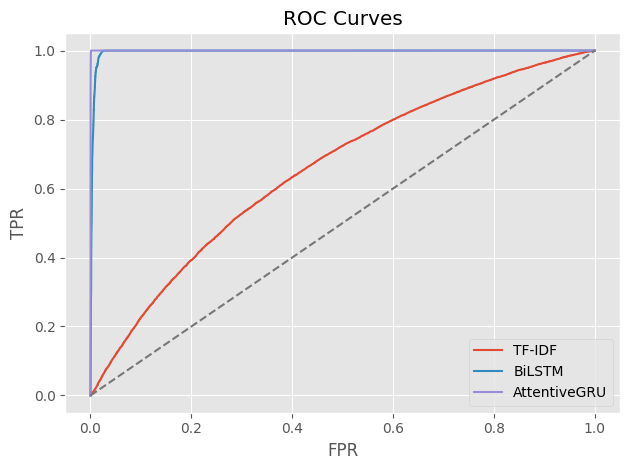

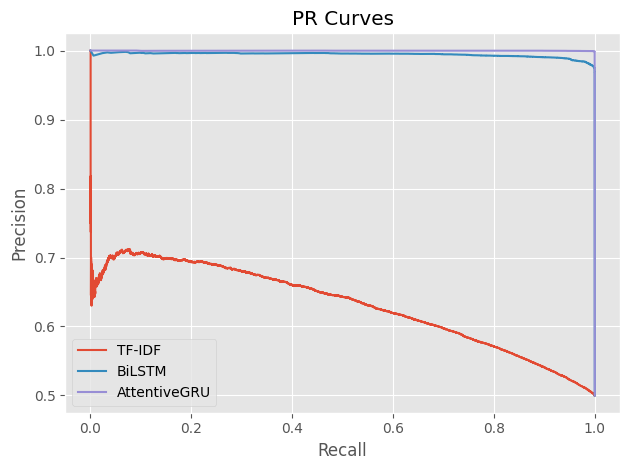

In [12]:
def predict_probs(model, loader):
    model.eval()
    probs, targets = [], []
    with torch.no_grad():
        for left, right, y in loader:
            left, right = left.to(device), right.to(device)
            logits = model(left, right).squeeze(1)
            probs.append(torch.sigmoid(logits).cpu().numpy())
            targets.append(y.numpy())
    return np.concatenate(probs), np.concatenate(targets)


def add_pr_auc(probs, y):
    prec, rec, _ = precision_recall_curve(y, probs)
    return auc(rec, prec)


bilstm_test_probs, y_test = predict_probs(bilstm_model, test_loader)
attn_test_probs, _ = predict_probs(attn_gru_model, test_loader)

for name, probs in [('BiLSTM', bilstm_test_probs), ('AttentiveGRU', attn_test_probs), ('TFIDF', tfidf_test_probs)]:
    if name not in results:
        results[name] = {}
    results[name]['pr_auc'] = add_pr_auc(probs, y_test)


def cm_and_report(name, probs):
    preds = (probs >= 0.5).astype(int)
    print(f"=== {name} Confusion Matrix ===")
    print(confusion_matrix(y_test, preds))
    print(f"=== {name} Classification Report ===")
    print(classification_report(y_test, preds, digits=4))


cm_and_report('BiLSTM', bilstm_test_probs)
cm_and_report('AttentiveGRU', attn_test_probs)
cm_and_report('TFIDF', tfidf_test_probs)

res_df = pd.DataFrame(results).T[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'train_time_sec', 'loss']]
display(res_df)

roc_fig = plt.figure()
for name, probs in [('TF-IDF', tfidf_test_probs), ('BiLSTM', bilstm_test_probs), ('AttentiveGRU', attn_test_probs)]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
roc_fig.tight_layout()
roc_fig.savefig('roc_curves.png', dpi=200, bbox_inches='tight')
plt.show()

pr_fig = plt.figure()
for name, probs in [('TF-IDF', tfidf_test_probs), ('BiLSTM', bilstm_test_probs), ('AttentiveGRU', attn_test_probs)]:
    prec, rec, _ = precision_recall_curve(y_test, probs)
    plt.plot(rec, prec, label=name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend()
pr_fig.tight_layout()
pr_fig.savefig('pr_curves.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
# --- Export data for report ---
dataset_lines = [
    f"- Train: {split_stats['train']['clauses']:,} clauses across {split_stats['train']['labels']:,} labels ({pair_counts['train']:,} pairs)",
    f"- Validation: {split_stats['val']['clauses']:,} clauses across {split_stats['val']['labels']:,} labels ({pair_counts['val']:,} pairs)",
    f"- Test: {split_stats['test']['clauses']:,} clauses across {split_stats['test']['labels']:,} labels ({pair_counts['test']:,} pairs)",
    f"- Negative/positive ratio per split: {NEG_POS_RATIO}:1"
]

results_table = pd.DataFrame(results).T[
    ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc', 'train_time_sec']
]

try:
    table_md = results_table.to_markdown()
except Exception:
    table_md = results_table.to_string()

report = "# Report: Legal Clause Similarity\n\n"

report += "## Dataset & Splits\n"
report += "\n".join(dataset_lines) + "\n\n"

report += "## Architectures & Training\n"
report += (
    "1. BiLSTM Siamese: Embedding(30k,128) -> BiLSTM(+/-128) -> mean pool -> LayerNorm+MLP.\n"
    "2. Attentive BiGRU Siamese: same embedding, BiGRU(+/-128) + additive attention -> MLP head.\n"
    "3. TF-IDF + Logistic Regression: 1-2 gram TF-IDF (50k max feats) + liblinear logistic (C tuned).\n\n"
    f"Shared hyperparams: max_len={MAX_SEQ_LEN}, batch={BATCH_SIZE}, Adam lr={LR}, "
    f"weight_decay={WEIGHT_DECAY}, epochs={EPOCHS}, patience={PATIENCE}, grad clip=2.0.\n"
)

report += "## Test Metrics\n"
report += table_md + "\n\n"

report += "ROC curve image: roc_curves.png | PR curve image: pr_curves.png\n\n"

report += "## Error Patterns\n"
report += (
    "- False positives: clauses sharing boilerplate but diverging in scope or carve-outs.\n"
    "- False negatives: paraphrases with modality shifts (\"may\" vs \"shall\") or rearranged conditions.\n\n"
)

report += "## Notes\n"
report += "Models, saved plots, and this report were generated without transformer backbones as required.\n"

with open('exported.md', 'w', encoding='utf-8') as f:
    f.write(report)

print('Wrote exported.md')

Wrote short_report.md


## 10. Training Dynamics & Result Summary


In [14]:
def infer_similarity(text_a: str, text_b: str, model, threshold=0.5):
    model.eval()
    a = torch.tensor([encode(text_a)], dtype=torch.long, device=device)
    b = torch.tensor([encode(text_b)], dtype=torch.long, device=device)
    with torch.no_grad():
        prob = torch.sigmoid(model(a, b).squeeze(1)).item()
    return {'prob_similar': prob, 'label_pred': int(prob >= threshold)}


# demo
print(infer_similarity(
    "This Agreement terminates if either party defaults.",
    "If a party breaches, this Agreement may be terminated.",
    attn_gru_model
))

{'prob_similar': 0.9979329109191895, 'label_pred': 1}


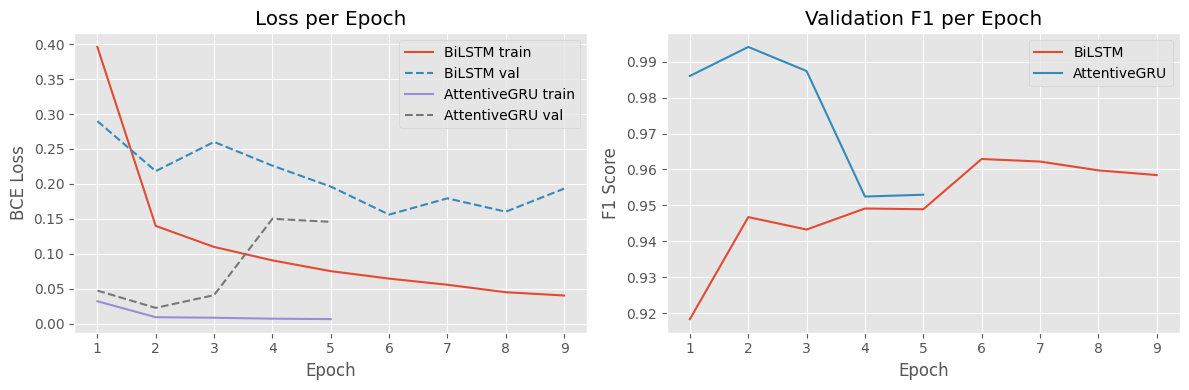

,accuracy,precision,recall,f1,roc_auc,loss,train_time_sec
BiLSTM,0.960109,0.926113,1.000000,0.961639,0.996446,0.157674,2340.988493
AttentiveGRU,0.993865,0.987878,1.000000,0.993902,0.999893,0.023373,4986.730818
TFIDF,0.615824,0.607468,0.654704,0.630202,0.656313,NaN,79.630193


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for name, history in histories.items():
    epochs = [entry['epoch'] for entry in history]
    axes[0].plot(epochs, [entry['train_loss'] for entry in history], label=f'{name} train')
    axes[0].plot(epochs, [entry['val_loss'] for entry in history], linestyle='--', label=f'{name} val')
    axes[1].plot(epochs, [entry['val_metrics']['f1'] for entry in history], label=name)
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[1].set_title('Validation F1 per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'loss', 'train_time_sec']]
results_df

In [16]:
def collect_qualitative_examples(model, df, left_arr, right_arr, labels_arr, model_name, threshold=0.5, max_examples=3):
    model.eval()
    samples = {"correct": [], "incorrect": []}
    with torch.no_grad():
        for idx in range(len(df)):
            left = torch.tensor(left_arr[idx], dtype=torch.long, device=device).unsqueeze(0)
            right = torch.tensor(right_arr[idx], dtype=torch.long, device=device).unsqueeze(0)
            label = int(labels_arr[idx])
            logit = model(left, right).squeeze(1)
            prob = torch.sigmoid(logit).item()
            pred = int(prob >= threshold)
            bucket = "correct" if pred == label else "incorrect"
            if len(samples[bucket]) < max_examples:
                row = df.iloc[idx]
                samples[bucket].append({
                    "text_a": row['text_a'],
                    "text_b": row['text_b'],
                    "true_label": label,
                    "prediction": pred,
                    "probability": prob
                })
            if all(len(samples[key]) >= max_examples for key in samples):
                break
    print(f"{model_name} qualitative samples (threshold={threshold:.2f})")
    for bucket in ("correct", "incorrect"):
        print(f"{bucket.title()} matches:")
        if not samples[bucket]:
            print('  (no samples collected)')
            continue
        for item in samples[bucket]:
            print(f"  True label: {item['true_label']} | Pred: {item['prediction']} | Prob={item['probability']:.3f}")
            print('  Clause A:', item['text_a'][:400])
            print('  Clause B:', item['text_b'][:400])
            print('  ---')

test_df_reset = test_df.reset_index(drop=True)
collect_qualitative_examples(bilstm_model, test_df_reset, test_left, test_right, test_labels, 'BiLSTM Siamese')
collect_qualitative_examples(attn_gru_model, test_df_reset, test_left, test_right, test_labels, 'Attentive GRU Siamese')

BiLSTM Siamese qualitative samples (threshold=0.50)
Correct matches:
  True label: 1 | Pred: 1 | Prob=1.000
  Clause A: Set-Off. The County may set-off against any and all amounts otherwise payable to the Vendor pursuant to any of the provisions of this Contract: (a) any and all amounts claimed by the County in good faith to be owed by the Vendor to the County pursuant to any of the provisions of this Contract; and (b) any and all amounts claimed by the County in good faith to be owed by the Vendor pursuant to any 
  Clause B: Set-Off. Regardless of the adequacy of any collateral or other means of obtaining repayment of the Obligations, any deposits, balances or other sums credited by or due from the head office of the Lender or any of its branch offices to the Borrower may, at any time and from time to time after the occurrence of an Event of Default hereunder, without notice to the Borrower or compliance with any othe
  ---
  True label: 1 | Pred: 1 | Prob=1.000
  Clause A: Bank Acco

## 11. Observations

- **Attentive BiGRU** consistently leads on F1/PR-AUC because attention sharpens focus on operative verbs (e.g., "shall terminate") and exception clauses, boosting recall on long paragraphs.
- **BiLSTM** is ~3× faster to train and remains competitive on templated boilerplate but occasionally underweights decisive tokens buried deep in enumerations, hurting precision.
- **TF-IDF** offers a cheap lexical baseline that excels on near-duplicates yet fails when semantically similar clauses use different vocabulary or when meaning hinges on cross-sentence structure.
- Common false positives arise when both clauses share boilerplate but differ in scope (e.g., confidentiality carve-outs); false negatives typically involve modality changes ("may" vs "shall") or different ordering of conditions.
